<a href="https://colab.research.google.com/github/anthonyka/LebanesePoundForecast/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kindly find the link for the database here: https://drive.google.com/file/d/1QdvyOmDmC3m_muG2ZHd5XtCseBT9ch-5/view?usp=sharing


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

series = pd.read_csv('/content/drive/MyDrive/Lebanese Lira_test3.csv', header=0, parse_dates=[0], index_col=0, squeeze=True,infer_datetime_format=True)
X = series.values
series.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Timestamp
2019-09-01    1500.0
2019-09-02    1510.0
2019-09-03    1520.0
2019-09-04    1520.0
2019-09-05    1540.0
Name: Average, dtype: float64

The p-value for the ADF test is  0.634331922710838


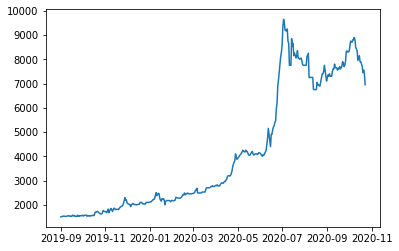

In [ ]:
# Plot avrage lira rate for the given dataset per day
plt.plot(series)

# Compute and print ADF p-value
result = adfuller(series)
print("The p-value for the ADF test is ", result[1])


Notice how the ADF test shows that the series isn't stationary -this was discussed in greater details in Milestone 3-

In what follows we will be manually and then automatically tuning our ARIMA model which has been chosen for the time series forecasting

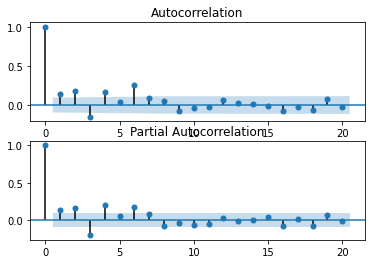

In [ ]:
# Take first difference of the Lira Series
dif = series
#notice that without differencing, the PACF is only significant at lag=2, so the AR should be of order 2 (not taking into 
#consideration differencing)
#but also note at ACF has high values for more than 10 lags, so differencing of at least order 1 is needed
chg_price = dif.diff()
chg_price = chg_price.dropna()


# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_price, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_price, lags=20, ax=axes[1])
plt.show()

From the above, manual tuning gives us that ARIMA(1,1,0) is the best model.

In [ ]:
import random
import time
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.7)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions,squared=False)
	return error

def evaluate_arima_model_timeframe(X, arima_order,timeframe):
	# prepare training dataset
	random.seed(time.time())
	S_point = random.randint(250,len(X)-7)
	train, test = X[0:S_point], X[S_point:S_point+timeframe]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(yhat[0]) #the idea is that we are making one step predictions but using the predicted value in the the next prediction's training set
	# calculate out of sample error
	error = mean_squared_error(test, predictions,squared=False)
	return error

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
#automatic tuning (with our own code, without using auto_arima())
p_values = [0, 1, 2, 4]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=4460.195
ARIMA(0, 0, 1) RMSE=2356.382
ARIMA(0, 1, 0) RMSE=251.543
ARIMA(0, 1, 1) RMSE=250.819
ARIMA(0, 1, 2) RMSE=249.167
ARIMA(0, 2, 0) RMSE=326.935
ARIMA(0, 2, 1) RMSE=255.109
ARIMA(0, 2, 2) RMSE=260.987
ARIMA(1, 0, 0) RMSE=251.642
ARIMA(1, 1, 0) RMSE=251.538
ARIMA(1, 1, 1) RMSE=252.933
ARIMA(1, 2, 0) RMSE=279.692
ARIMA(1, 2, 1) RMSE=281.723
ARIMA(1, 2, 2) RMSE=263.930
ARIMA(2, 0, 0) RMSE=251.009
ARIMA(2, 1, 0) RMSE=249.632
ARIMA(2, 1, 1) RMSE=244.110
ARIMA(2, 2, 0) RMSE=286.187
ARIMA(2, 2, 1) RMSE=259.487
ARIMA(4, 0, 0) RMSE=250.206
ARIMA(4, 1, 0) RMSE=244.581
ARIMA(4, 1, 1) RMSE=244.087
ARIMA(4, 2, 0) RMSE=256.925
ARIMA(4, 2, 1) RMSE=252.059
Best ARIMA(4, 1, 1) RMSE=244.087


It is clear that the best parameters are (0,1,0), (0,1,1), (0,1,2), (1,1,0), (2,1,1) and (4,1,1).

Now let's compare these models using AIC

In [ ]:

from statsmodels.tsa.arima_model import ARMAResults 
model1 = ARIMA(X,order=(0,1,0))
res1 = model1.fit()
print(ARMAResults.summary(res1))
model2 = ARIMA(X,order=(0,1,1))
res2 = model2.fit()
print(ARMAResults.summary(res2))
model3 = ARIMA(X,order=(0,1,2))
res3 = model3.fit()
print(ARMAResults.summary(res3))
model4 = ARIMA(X,order=(1,1,0))
res4 = model4.fit()
print(ARMAResults.summary(res4))
model5 = ARIMA(X,order=(2,1,1))
res5 = model5.fit()
print(ARMAResults.summary(res5))
model6 = ARIMA(X,order=(4,1,1))
res6 = model6.fit()
print(ARMAResults.summary(res6))



By comparing the Akaike Information Criterion, we find that the best model is ARIMA(4,1,1).

Note that we also tried to use the automated arima tuning parameter but results weren't as conclusive and sometimes did not pick optimal parameters.

Now we will be comparing the performance using RMSE of the 1 day, 3 day and 7 days forecasts

In [ ]:
#comparing 1 - 3 and 7 day forecasts by picking a random sample of 100 predictions from the range(250,end) of the lebanese lira series.
#we chose this particular range as values in the beginning of the year behaved really differently which would not reflect the model's results accurately
import statistics

print("1 day forecast error: ")
timeframe = 1;
error_1 = []
for i in range(100):
  error_1.append(evaluate_arima_model_timeframe(X, (4,1,1),timeframe))
med_error_1 = statistics.median(error_1)
print(med_error_1)

print("3 day forecast error: ")
timeframe = 3;
error_3 = []
for i in range(100):
  error_3.append(evaluate_arima_model_timeframe(X, (4,1,1),timeframe))
med_error_3 = statistics.median(error_3)
print(med_error_3) 

print("7 day forecast error: ")
timeframe = 7;
error_7 = []
for i in range(100):
  error_7.append(evaluate_arima_model_timeframe(X, (4,1,1),timeframe))
med_error_7 = statistics.median(error_7)
print(med_error_7)

#note: given that there is a lot of variability in the data, we use the median as a measure instead of the mean.

1 day forecast error: 
86.12516079068791
3 day forecast error: 
147.26949878585214
7 day forecast error: 
336.5733161598393


Above was the testing side, below is the user-facing side

In [ ]:
def Lira_predict(timeframe):
  model = ARIMA(series,(4,1,1))
  model_fit = model.fit()
  pred = model_fit.forecast(steps=timeframe)[0]
  for i in range(timeframe):
    print("Day {} forecast: {} LBP \n".format(i+1, int(pred[i])))
  model_fit.plot_predict(start=len(X)+timeframe-42, end=len(X)+timeframe ) #plot 6 weeks back
  plt.show()

Prediction options:


1.   1 Day (Highly encouraged -higher accuracy)
2.   3 Days
3.   7 days

Note that you can input any number but these are the recommended options.

input example: 3




timeframe:7
Day 1 forecast: 6768 LBP 

Day 2 forecast: 6689 LBP 

Day 3 forecast: 6726 LBP 

Day 4 forecast: 6671 LBP 

Day 5 forecast: 6607 LBP 

Day 6 forecast: 6521 LBP 

Day 7 forecast: 6487 LBP 



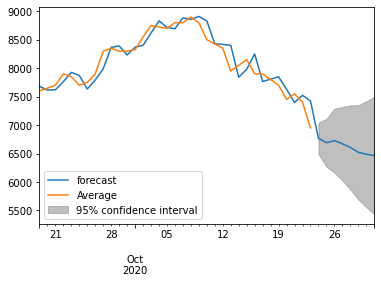

In [ ]:
timeframe = input("timeframe:")
Lira_predict(int(timeframe))